In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
plt.rcParams['mathtext.fontset'] = 'stix'

import functools
import re
from multiprocessing import Pool
import itertools

### Defining labels and corresponding state positions

In [3]:
# states
L = -5.4
R = 5.4

# index
bins=np.arange(-15., 17, 1)
idx_L=np.digitize(L, bins)
idx_R=np.digitize(R, bins)

### Defining functions for counting transitions

In [4]:
def within(coordinate, center, radius):
    """
    Determine whether a coordinate is within the predefined center.
    """
    return np.linalg.norm(coordinate - center) <= radius


def classify(coordinate, radius):
    """
    Classify coordinates as labels.
    """
    if within(coordinate, idx_L, radius):
        return "L"
    elif within(coordinate, idx_R, radius):
        return "R"
    else:
        return "N"
    
    
def count(data, commit):
    
    # Convert 1*commit A,B,C by a,b,c
    data = data.replace('L' * commit, 'l')
    data = data.replace('R' * commit, 'r')
    
    # Remove remained A,B,C, and N.
    data = data.replace('L', "") # Remove all A's
    data = data.replace('R', '')
    data = data.replace('N', '')
    
    # Convert a,b,c back to A,B,C. I think it should be okay to process with just X,Y,Z
    data = data.replace('l', 'L')
    data = data.replace('r', 'R')
    
    # Now note here that each A,B,C are actually represent 1*commit A,B,C. AA+ means there are at least 2*commit A. 
    # Here replacing AA+ by A.
    data = re.sub('LL+', 'L', data)
    data = re.sub('RR+', 'R', data)
        
    n1 = data.count("LR")
    n2 = data.count("RL")
    
    return n1, n2


def find_plateau(count_arr):
    """
    The input should be just one count arr, e.g. res[i].
    How do I determine a plateau? 
    1. Plateau with commit time > 10, 
    2. Plateau should be at least 2-step long.
    """
    for i in range(5,len(count_arr)-1):
        if count_arr[i+1]==count_arr[i]:
            return count_arr[i]

    return count_arr[-1]


def count_arr(data_array):
    """
    Counts vs commit times from the input data_array.
    
    """
    # Choose the range of commit time. L=10 and R=21, so transition must be at least 5 steps.
    commits = list(range(5,20, 1))
    
    # Convert data_array to "L" and "R"
    data = "".join(list(map(functools.partial(classify, radius=1), data_array)))

    # Count transitions vs commit times
    count_partial = functools.partial(count, data)
    
    res = list(map(count_partial, commits))
    res = list(zip(*res))
    
    return res

### Read data

In [11]:
pred2=[]
for i in range(10):
    pdfile = './N_mean0_42/Output-conc/{}/prediction.npy'.format(i)
    prediction2 = np.load(pdfile)
    pred2.append(prediction2)

### Analyze

In [6]:
# Pick one segment from data
i=17
segment_len=200000
data_array=pred2[0][i*segment_len:(i+1)*segment_len]
# Choose the range of commit time. L=10 and R=21, so transition must be at least 5 steps.
commits = list(range(5,20, 1))
# Convert data_array to "L" and "R"
data = "".join(list(map(functools.partial(classify, radius=1), data_array)))

# Count transitions vs commit times
count2 = functools.partial(count, data)

p = Pool(4)
res = list(p.map(count2, commits))
res = list(zip(*res))

### Make commit time plot

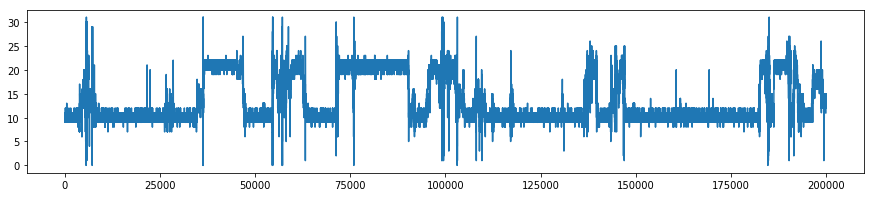

In [7]:
plt.rcParams["figure.figsize"] = (15,3)
plt.plot(data_array);

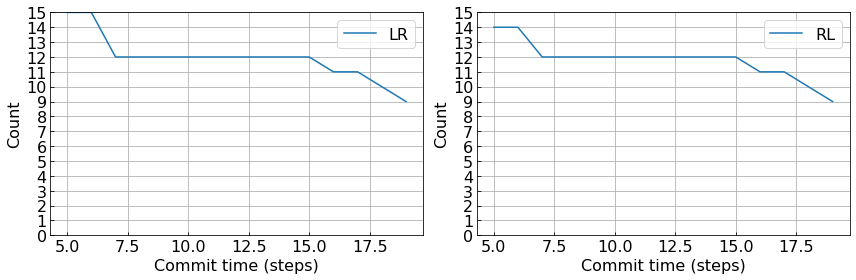

In [8]:
fig, ax=plt.subplots(figsize=(12,4), nrows=1, ncols=2)
ax=ax.flatten()


pairs = ['LR', 'RL']
ax[0].plot(commits, res[0], label='{}'.format(pairs[0]))
ax[1].plot(commits, res[1], label='{}'.format(pairs[1]))


ax[0].tick_params(axis='both', which='both', direction='in', labelsize=16)
ax[0].set_xlabel('Commit time (steps)', size=16)
ax[0].legend(loc='upper right', fontsize=16)
ax[0].set_ylabel('Count', size=16)
ax[0].set_yticks(np.arange(20))
ax[0].set_ylim(0,15)
ax[0].grid()

ax[1].tick_params(axis='both', which='both', direction='in', labelsize=16)
ax[1].set_xlabel('Commit time (steps)', size=16)
ax[1].legend(loc='upper right', fontsize=16)
ax[1].set_ylabel('Count', size=16)
ax[1].set_yticks(np.arange(20))
ax[1].set_ylim(0,15)
ax[1].grid()

fig.tight_layout()
plt.show()

### Compute for one trajectory

In [12]:
N_val = {}
# This for loop can be paralleled.
for i in range(20):

    # Pick one segment from data
    segment_len=200000
    data_array = pred2[0][i*segment_len:(i+1)*segment_len]

    N_val[i] = list(map(find_plateau, count_arr(data_array)))

In [13]:
N_arr = np.array(list(N_val.values()))
t_arr = segment_len/N_arr

In [21]:
# Mean transition time
mean_t = len(pred2[0])*0.05/np.sum(N_arr, axis=0)
stdv_t = np.std(t_arr*0.05, axis=0)/np.sqrt(len(N_arr))

### Transition time ($ps$)

In [24]:
mean_t, stdv_t

(array([884.95575221, 881.05726872]), array([67.29477241, 67.40845086]))

### Calculate averaged over 10 independent training and runs

In [12]:
def traj_i(traj):

    N_val = {}
    # This for loop can be paralleled.
    for i in range(20):

        # Pick one segment from data
        segment_len=200000
        data_array = traj[i*segment_len:(i+1)*segment_len]

        N_val[i] = list(map(find_plateau, count_arr(data_array)))
    
    
    N_arr = np.array(list(N_val.values()))
    t_arr = segment_len/N_arr
    
    # Mean transition time
    mean_t = len(traj)*0.05/np.sum(N_arr, axis=0)
    stdv_t = np.std(t_arr*0.05, axis=0)/np.sqrt(len(N_arr))
    
    return mean_t, stdv_t


mean_t_arr = []
stdv_t_arr = []
for i in range(10):
    
    traj = pred2[i]
    
    mean_t_i, stdv_t_i = traj_i(traj)
    
    mean_t_arr.append(mean_t_i)
    stdv_t_arr.append(stdv_t_i)
    print(i)

0
1
2
3
4
5
6
7
8
9


In [13]:
mean_t_arr = np.array(mean_t_arr)
mean_t_arr

array([[ 884.95575221,  881.05726872],
       [ 956.93779904,  966.18357488],
       [ 699.3006993 ,  694.44444444],
       [1379.31034483, 1388.88888889],
       [ 743.49442379,  754.71698113],
       [ 947.86729858,  952.38095238],
       [1086.95652174, 1092.89617486],
       [ 787.4015748 ,  790.51383399],
       [ 766.2835249 ,  760.45627376],
       [ 947.86729858,  943.39622642]])

In [14]:
mean_t = np.mean(mean_t_arr,axis=0)
mean_t

array([920.03752378, 922.49346195])

In [15]:
stdv_t_arr = np.array(stdv_t_arr)
stdv_t_arr

array([[ 67.29477241,  67.40845086],
       [ 51.50740083,  48.92311183],
       [ 38.98739255,  35.41597137],
       [ 89.15685113, 103.13287329],
       [ 47.5440516 ,  47.6499896 ],
       [ 66.92836383,  54.40010507],
       [ 93.38973937,  98.37221889],
       [ 41.58132739,  43.61701303],
       [ 49.58333422,  44.86864128],
       [ 61.31430232,  60.89949826]])

In [16]:
stdv_t = np.sqrt(np.mean(stdv_t_arr**2, axis=0))
stdv_t

array([63.29218218, 64.31129354])